In [1]:
from datetime import datetime as dt

start = dt.now()


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Bidirectional
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
%matplotlib inline

In [3]:
df = pd.read_csv("time_series_covid19_confirmed_global.csv")
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [4]:
df.set_index('Country/Region', inplace=True)
india_data = df.loc['India']
india_data = india_data.drop(['Province/State', 'Lat', 'Long'])
india_data = india_data.transpose()
india_data.columns = ["Total Confirmed"]
data = pd.DataFrame(india_data)
data['India'] = pd.to_numeric(data['India'], errors='coerce')
data = data.rename(columns={'India': 'Total Confirmed'})

In [5]:
data.head()

,Total Confirmed
1/22/20,0
1/23/20,0
1/24/20,0
1/25/20,0
1/26/20,0


In [6]:
print(data.index)

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '2/28/23', '3/1/23', '3/2/23', '3/3/23', '3/4/23', '3/5/23', '3/6/23',
       '3/7/23', '3/8/23', '3/9/23'],
      dtype='object', length=1143)


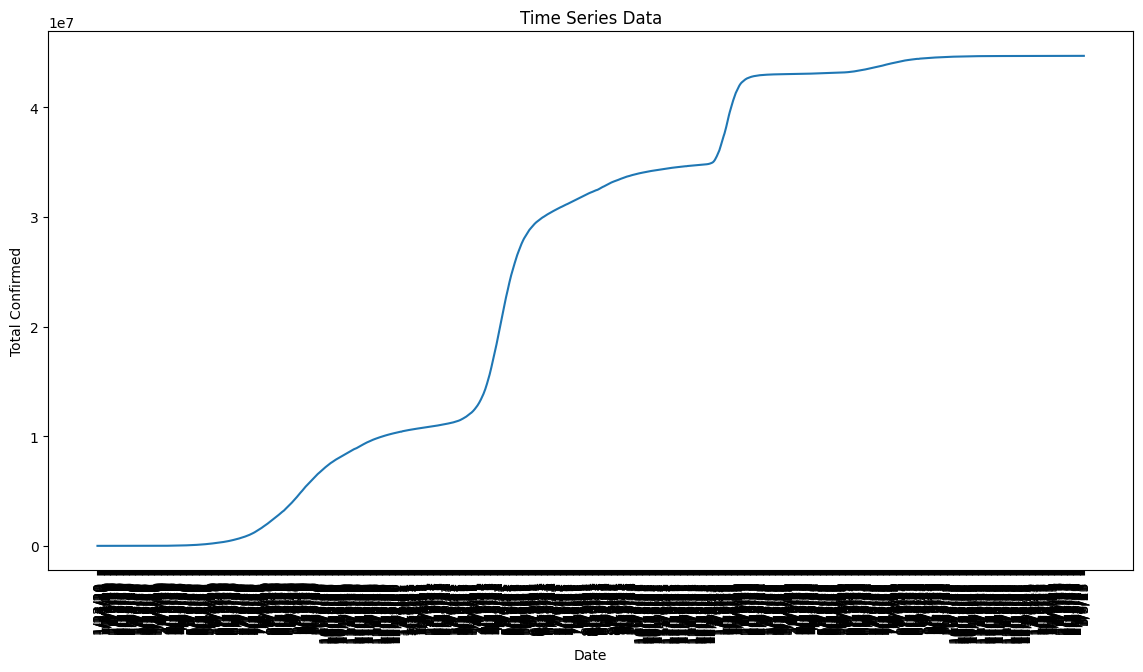

In [7]:
sub_df = data[data.index >= "2020-01-22"]
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Total Confirmed'])
plt.xlabel('Date')
plt.ylabel('Total Confirmed')
plt.xticks(rotation = "vertical")
plt.title('Time Series Data')
plt.show()

In [8]:

results = adfuller(data['Total Confirmed'])
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])
print('Critical Values:')
for key, value in results[4].items():
  print('\t%s: %.3f' % (key, value))
#Here we can see that the p-value is less than 0.05 this means our null hypothesis will be accepted and we will take this series as stationary

ADF Statistic: -1.268995
p-value: 0.643235
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


<Axes: >

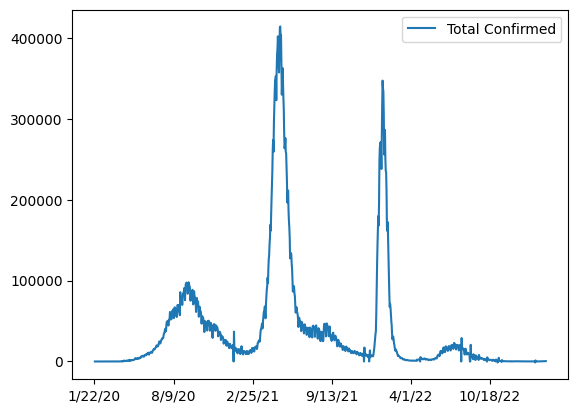

In [9]:
data.diff().plot()

<Axes: >

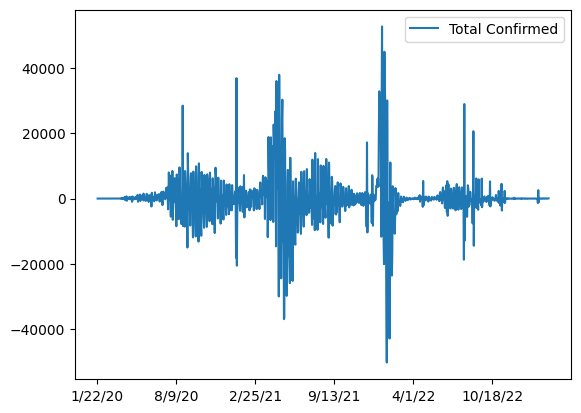

In [10]:
data.diff().diff().plot() #d=2

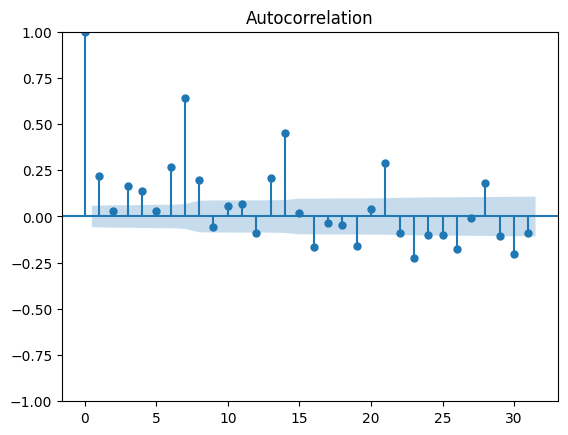

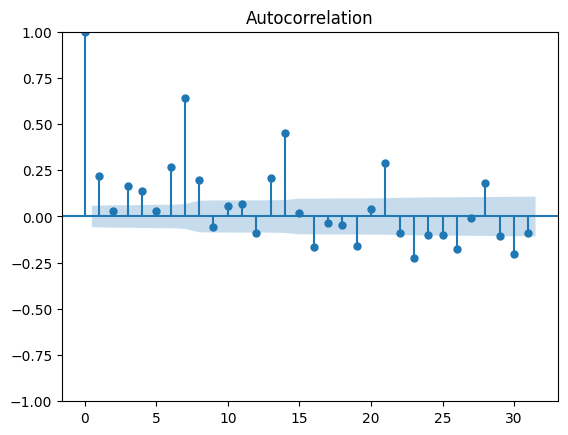

In [11]:
plot_acf(data.diff().diff().dropna())#q=2

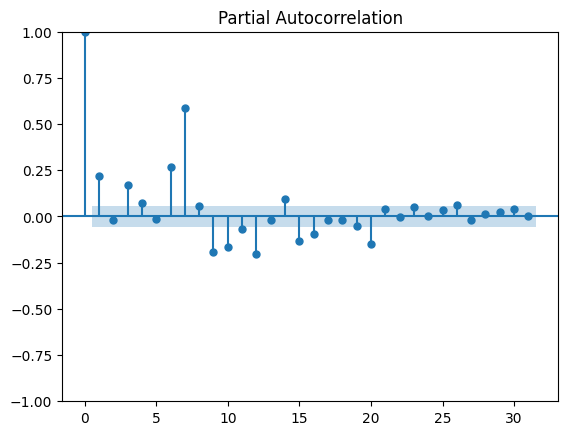

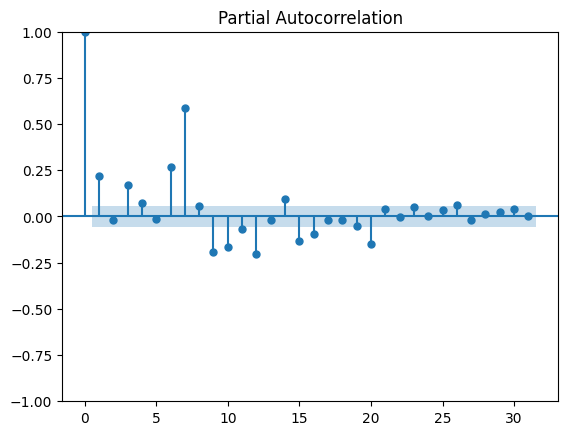

In [12]:
plot_pacf(data.diff().diff().dropna())#p=2

In [13]:
len_training = int(len(data)*.8)
df_train,df_test = data[:len_training], data[len_training:]

In [14]:
df_train.shape

(914, 1)

In [15]:
df_test.shape

(229, 1)

In [16]:
predicted_list, error_list = [], []

In [17]:
# Fit ARIMA model using training data
model = ARIMA(df_train, order=(2, 2, 2))
model_fit = model.fit()

# Make predictions for the entire test set
predicted_values = model_fit.predict(start = len(df_train), end = 1143, dynamic=True)

# Iterate through the test set to calculate errors and print predictions
for t in range(len(df_test)):
    # Extract observed value from the test set
    obs = df_test.iloc[t]['Total Confirmed']

    # Extract predicted value from the predictions array
    predicted_value = predicted_values[t]

    # Calculate absolute error between observed and predicted values
    error = abs(predicted_value - obs)

    # Append error and predicted value to lists
    error_list.append(obs - predicted_value)
    predicted_list.append(predicted_value)

    # Print prediction details
    print(f"predicted={predicted_value}, expected={obs}, error={error}")

c:\Users\Somit Jain\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Somit Jain\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Somit Jain\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


predicted=43908604.0485535, expected=43905621, error=2983.048553496599
predicted=43928838.94037757, expected=43920451, error=8387.940377570689
predicted=43948839.655931205, expected=43938764, error=10075.655931204557
predicted=43969071.263499856, expected=43959321, error=9750.263499855995
predicted=43989179.16279208, expected=43979730, error=9449.16279207915
predicted=44009428.269101046, expected=44000138, error=9290.269101046026
predicted=44029615.58298836, expected=44019811, error=9804.582988359034
predicted=44049891.82044332, expected=44036275, error=13616.820443317294
predicted=44070140.59542869, expected=44050009, error=20131.595428690314
predicted=44090447.48783765, expected=44067144, error=23303.487837649882
predicted=44110745.61620139, expected=44087037, error=23708.616201393306
predicted=44131083.427605025, expected=44107588, error=23495.42760502547
predicted=44151422.35311151, expected=44126994, error=24428.35311151296
predicted=44171789.68795111, expected=44145709, error=260

In [18]:
print(error_list)
print(len(error_list))

[-2983.048553496599, -8387.940377570689, -10075.655931204557, -9750.263499855995, -9449.16279207915, -9290.269101046026, -9804.582988359034, -13616.820443317294, -20131.595428690314, -23303.487837649882, -23708.616201393306, -23495.42760502547, -24428.35311151296, -26080.687951110303, -46454.07135807723, -37907.76480349153, -42263.70016757399, -46384.30587135255, -50251.85381991416, -54878.90420784801, -61237.80839321762, -66782.94718953222, -77923.45729186386, -89858.50095543265, -97738.25825674087, -102480.21847150475, -109711.17869342864, -118682.2640747577, -129667.64285418391, -141604.2500726506, -151483.48256824166, -161292.18256689608, -171574.8922006786, -182598.4146155417, -193710.38797441125, -206671.60541785508, -227227.77150764316, -247787.68455962837, -247735.0972836092, -262133.8205826804, -275484.6437150985, -289248.39329265803, -303913.8874557018, -320074.9693246111, -337856.4806212187, -349464.2805621922, -363956.23060741276, -378989.205065608, -394502.08221728355, -40

In [19]:
print(df_test['Total Confirmed'].values)
print(len(df_test['Total Confirmed'].values))
print(len(predicted_values))

[43905621 43920451 43938764 43959321 43979730 44000138 44019811 44036275
 44050009 44067144 44087037 44107588 44126994 44145709 44145709 44174650
 44190697 44206996 44223557 44239372 44253464 44268381 44277711 44286256
 44298864 44314618 44327890 44339429 44348960 44357546 44368195 44378920
 44389176 44398696 44408132 44415723 44415723 44415723 44436339 44442507
 44449726 44456535 44462445 44466862 44469661 44478636 44484729 44490283
 44495359 44500580 44502363 44510057 44516479 44522777 44528524 44534188
 44539046 44543089 44545011 44553042 44558425 44563337 44568114 44572243
 44575473 44579088 44583360 44587307 44591112 44594487 44597498 44599466
 44601892 44604463 44606460 44609257 44612013 44614437 44616394 44616235
 44621319 44623997 44626427 44628828 44630888 44632430 44634376 44636517
 44638636 44640748 44642742 44644076 44644938 44645768 44646880 44649088
 44650662 44652256 44653592 44654638 44655828 44655926 44658365 44659447
 44660579 44661504 44660293 44660293 44660293 44664

In [20]:

MAPE = mean_absolute_percentage_error(df_test['Total Confirmed'].values, predicted_values[:-1])
print("MAPE:", MAPE)

MAPE: 0.037593048771388346


In [21]:
# model = ARIMA(df_train, order=(2,2,2))
# model_fit = model.fit()
training_error = model_fit.resid

In [22]:
training_error

1/22/20       0.000000
1/23/20       0.000000
1/24/20       0.000000
1/25/20       0.000000
1/26/20       0.000000
              ...     
7/19/22    2988.039918
7/20/22    4215.503431
7/21/22   -1724.634056
7/22/22    -708.708303
7/23/22   -1702.480886
Length: 914, dtype: float64

In [23]:
training_error.shape

(914,)

LSTM

In [24]:
len(training_error)

914

In [25]:
train = training_error
new_train = []
for i in train:
    new_train.append(i)
new_train = np.array(new_train)
test = error_list
new_test = []
for i in test:
    new_test.append(i)
new_test = np.array(new_test)

In [26]:
new_train.shape

(914,)

In [27]:
new_test.shape

(229,)

In [28]:
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()
# data.head(),df.tail()
scaled_train = scaler_train.fit_transform(new_train.reshape(-1, 1))
scaled_test = scaler_test.fit_transform(new_test.reshape(-1, 1))
scaled_train[:10]


array([[0.51080251],
       [0.51080251],
       [0.51080251],
       [0.51080251],
       [0.51080251],
       [0.51080251],
       [0.51080251],
       [0.51080251],
       [0.51081402],
       [0.51078828]])

In [29]:
split_ratio = 0.8 
split_index = int(len(scaled_train) * split_ratio)
scaled_train_final = scaled_train[:split_index]
scaled_validation_data = scaled_train[split_index:]
print(scaled_train_final.shape)
print(scaled_validation_data.shape)
n_input = 20
n_features = 1
generator = TimeseriesGenerator(scaled_train_final, scaled_train_final, length=n_input, batch_size=1)


(731, 1)
(183, 1)


In [30]:
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True), input_shape=(n_input, n_features)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(1))
optimizer = RMSprop(learning_rate=0.001)  # Adjust learning rate if needed
model.compile(optimizer=optimizer, loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [31]:
validation_generator = TimeseriesGenerator(scaled_validation_data, scaled_validation_data, length=n_input, batch_size=1)

model.fit(generator, epochs=100, callbacks=[early_stopping], validation_data=validation_generator)

Epoch 1/100
711/711 [==============================] - 21s 21ms/step - loss: 0.0139 - val_loss: 0.0014
Epoch 2/100
711/711 [==============================] - 14s 19ms/step - loss: 0.0107 - val_loss: 0.0081
Epoch 3/100
711/711 [==============================] - 12s 17ms/step - loss: 0.0107 - val_loss: 0.0081
Epoch 4/100
711/711 [==============================] - 10s 14ms/step - loss: 0.0101 - val_loss: 0.0110
Epoch 5/100
711/711 [==============================] - 11s 15ms/step - loss: 0.0093 - val_loss: 0.0011
Epoch 6/100
711/711 [==============================] - 10s 14ms/step - loss: 0.0090 - val_loss: 0.0025
Epoch 7/100
711/711 [==============================] - 10s 15ms/step - loss: 0.0089 - val_loss: 0.0013
Epoch 8/100
711/711 [==============================] - 11s 15ms/step - loss: 0.0092 - val_loss: 9.3560e-04
Epoch 9/100
711/711 [==============================] - 10s 15ms/step - loss: 0.0086 - val_loss: 0.0048
Epoch 10/100
711/711 [==============================] - 10s 14ms/step

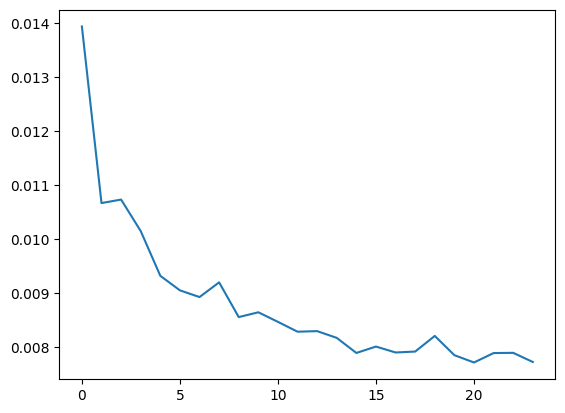

In [32]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)


In [33]:
last_train_batch = scaled_train[-20:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)


1/1 [==============================] - 1s 875ms/step


array([[0.5122267]], dtype=float32)

In [34]:
scaled_test[0]


array([1.])

In [35]:
print(len(test))

229


In [36]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
test_predictions

1/1 [==============================] - 0s 21ms/step


[array([0.5122267], dtype=float32),
 array([0.51183796], dtype=float32),
 array([0.5122559], dtype=float32),
 array([0.51245123], dtype=float32),
 array([0.51239884], dtype=float32),
 array([0.51230615], dtype=float32),
 array([0.51216006], dtype=float32),
 array([0.5119679], dtype=float32),
 array([0.5116675], dtype=float32),
 array([0.5121811], dtype=float32),
 array([0.5124959], dtype=float32),
 array([0.5124665], dtype=float32),
 array([0.5123532], dtype=float32),
 array([0.512333], dtype=float32),
 array([0.5118738], dtype=float32),
 array([0.5118364], dtype=float32),
 array([0.51226383], dtype=float32),
 array([0.5127689], dtype=float32),
 array([0.5125087], dtype=float32),
 array([0.51239586], dtype=float32),
 array([0.5121733], dtype=float32),
 array([0.5121743], dtype=float32),
 array([0.5121709], dtype=float32),
 array([0.5121714], dtype=float32),
 array([0.51217335], dtype=float32),
 array([0.51217437], dtype=float32),
 array([0.5121741], dtype=float32),
 array([0.5121717], 

In [37]:
true_predictions = scaler_test.inverse_transform(test_predictions)
new_test = pd.DataFrame(new_test)
# new_test.head()
new_test.rename(columns={'O': 'error'}, inplace=True)
new_test['Predictions'] = true_predictions
new_test.head()

,0,Predictions
0,-2983.048553,-1.908756e+06
1,-8387.940378,-1.910275e+06
2,-10075.655931,-1.908642e+06
3,-9750.263500,-1.907879e+06
4,-9449.162792,-1.908083e+06


In [38]:
print(len(new_test))

229


In [39]:
print(len(predicted_list))
print(len(true_predictions))

229
229


In [40]:
print((predicted_list+true_predictions)[0])

[41999848.18226495 42020083.07408902 42040083.78964266 42060315.39721131
 42080423.29650353 42100672.4028125  42120859.71669981 42141135.95415477
 42161384.72914015 42181691.6215491  42201989.74991284 42222327.56131648
 42242666.48682296 42263033.82166256 42283407.20506953 42303801.89851494
 42324204.83387902 42344624.43958281 42365052.98753136 42385495.0379193
 42405945.94210467 42426408.08090098 42446878.59100331 42467358.63466689
 42487846.39196819 42508342.35218295 42528845.31240489 42549355.39778621
 42569871.77656564 42590394.3837841  42610922.61627969 42631456.31627835
 42651995.02591214 42672538.548327   42693086.52168587 42713638.7391293
 42734194.90521909 42754754.81827109 42775318.23099506 42795884.95429413
 42816454.77742656 42837027.52700411 42857603.02116716 42878181.10303606
 42898761.61433268 42919344.41427365 42939929.36431886 42960516.33877707
 42981105.21592873 43001695.88392115 43022288.23555006 43042882.17148376
 43063477.59715098 43084074.42445648 43104672.5698865

In [41]:
pred_final = true_predictions + predicted_list

229
(229, 229)


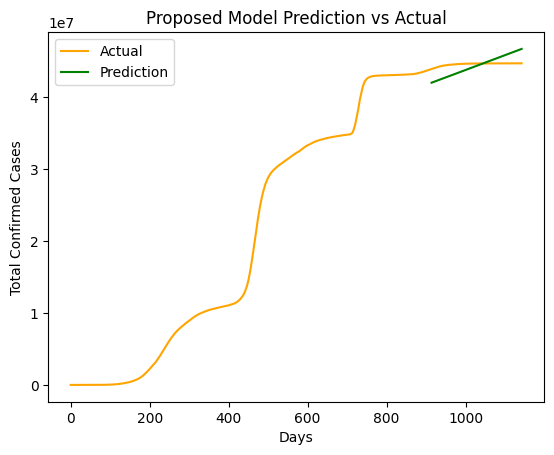

In [42]:

start_index = len(data) - len(pred_final)
year_pred = np.arange(start_index,len(data))
dates = data.index
year_new = np.arange(len(dates))
total_confirmed = data['Total Confirmed'].values
plt.plot(year_new, total_confirmed, label='Actual',color = "orange")
plt.plot(year_pred, pred_final[0], label='Prediction',color = "green")
plt.legend()
print(len(year_pred))
print(pred_final.shape)
plt.title('Proposed Model Prediction vs Actual')
plt.xlabel('Days')
plt.ylabel('Total Confirmed Cases')
plt.show()

In [43]:
print(len(pred_final))
print(len(df_test['Total Confirmed']))

229
229


In [44]:
error = mean_absolute_percentage_error(df_test['Total Confirmed'].to_list(),pred_final[0])*100
print('Test MAPE: %.4f' % error)
mdape = np.median((np.abs(np.subtract(df_test['Total Confirmed'].to_list(), pred_final[0])/df_test['Total Confirmed'].to_list())))*100
print('Test MDAPE: %.4f' % mdape)
smape = 100/len(df_test['Total Confirmed'].values) * np.sum(2 * np.abs(df_test['Total Confirmed'].values - pred_final[0]) / (np.abs(df_test['Total Confirmed'].values) + np.abs(pred_final[0])))
print('SMAPE: %.4f' % smape)

Test MAPE: 2.4572
Test MDAPE: 2.5566
SMAPE: 2.4680


In [45]:
error = mean_absolute_percentage_error(df_test['Total Confirmed'].to_list(),pred_final[0])
print('Test MAPE: %f' % error)

Test MAPE: 0.024572


In [46]:
mdape = np.median((np.abs(np.subtract(df_test['Total Confirmed'].to_list(), pred_final[0])/df_test['Total Confirmed'].to_list())))*100
print('Test MDAPE: %f' % mdape)


Test MDAPE: 2.556622


In [47]:
smape = 100/len(df_test['Total Confirmed'].values) * np.sum(2 * np.abs(df_test['Total Confirmed'].values - pred_final[0]) / (np.abs(df_test['Total Confirmed'].values) + np.abs(pred_final[0])))
print('SMAPE: ', smape)

SMAPE:  2.4679826127403293


In [48]:
df = pd.read_csv('graph.csv')
df['Proposed Model'] = pred_final[0]
df.to_csv('graph.csv', index=False)

In [49]:
running_secs = (dt.now()-start).seconds
running_secs

296